## Convolutional Neural Network

In [1]:

import pathlib
import tensorflow as tf
from tensorflow.keras import layers


In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/Image_Classification/seg_train/seg_train', batch_size=128, label_mode='categorical', color_mode='rgb', image_size=(150,150), subset='training', validation_split=0.1, seed=1)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/Image_Classification/seg_train/seg_train', batch_size=128, label_mode='categorical', color_mode='rgb', image_size=(150,150), subset='validation', validation_split=0.1, seed=1)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/Image_Classification/seg_test/seg_test', batch_size=128, label_mode='categorical', color_mode='rgb', image_size=(150,150), )

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.


In [7]:
regularizer = tf.keras.regularizers.l1(0.001)

model = tf.keras.Sequential(
  [
    layers.Input(shape=(150,150,3)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizer),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizer),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizer),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizer),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizer),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
    layers.Dense(6, activation='softmax')
  ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 average_pooling2d (AverageP  (None, 74, 74, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 average_pooling2d_1 (Averag  (None, 36, 36, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 average_pooling2d_2 (Averag  (None, 17, 17, 16)       0

In [ ]:
# First epoch very slow but then it speeds up
batch_size=512
epochs=100

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data=validation_dataset)

# score = model.evaluate(x_test, y_test)
# print('Test loss: ', score[0])
# print('Test accuracy: ', score[1])

In [ ]:
model.fit(train_dataset, batch_size=batch_size,
          epochs=epochs, validation_data=validation_dataset)


In [ ]:
model.save('./trainedModel')

In [2]:
model = tf.keras.models.load_model('./trainedModel')

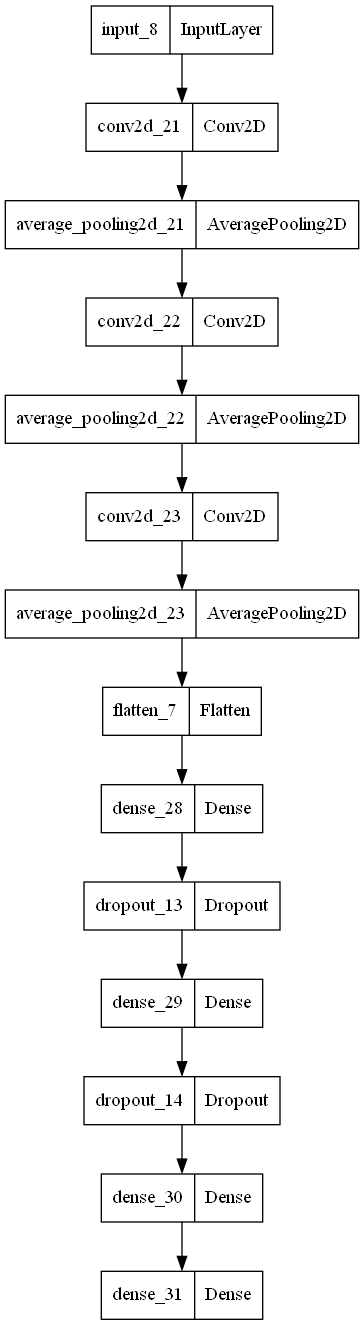

In [4]:
tf.keras.utils.plot_model(model, to_file='./cnnPlot.png')


In [10]:
test_ds = [[],[]]
for image,labels in test_dataset:
  labs = labels
  for item in labs:
    test_ds[1].append(item)
  for img in image:
    test_ds[0].append(img)
    

94/94 [==============================] - 1s 7ms/step
5
5
Confusion matrix:


Text(0, 0.5, 'Prediction')

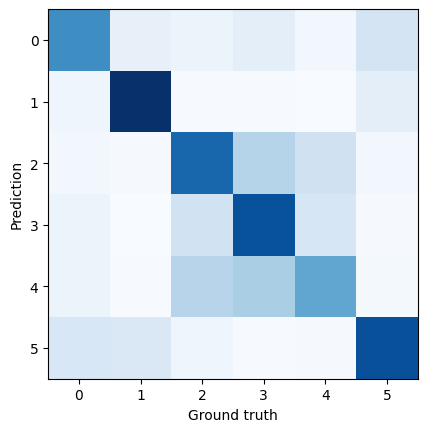

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
y_pred = model.predict(np.array(test_ds[0]))

predicted_categories = np.argmax(y_pred, axis=1)
print(predicted_categories[0])
true_categories_argmax = np.argmax(test_ds[1], axis=1)
print(true_categories_argmax[0])
print('Confusion matrix:')
cm = confusion_matrix(true_categories_argmax, predicted_categories)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')


In [16]:
y_pred = model.predict(np.array(test_ds[0]))

predicted_categories = np.argmax(y_pred, axis=1)
true_categories_argmax = np.argmax(test_ds[1], axis=1)
print(classification_report(true_categories_argmax, predicted_categories))


94/94 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       437
           1       0.81      0.86      0.83       474
           2       0.57      0.58      0.58       553
           3       0.54      0.67      0.60       525
           4       0.57      0.43      0.49       510
           5       0.73      0.71      0.72       501

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



### Fine tuning

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import pathlib
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = './Datasets/Image_Classification/seg_train/seg_train/'
test_dir = './Datasets/Image_Classification/seg_test/seg_test/'

generator = ImageDataGenerator(
  rescale=1.0/255,
  shear_range=0.2,
  zoom_range=0.5,
  horizontal_flip=True,
  rotation_range=15,
  width_shift_range=0.25,
  brightness_range=[0.3,1.3],
  validation_split=0.2,
  preprocessing_function=preprocess_input
)

train_dataset = generator.flow_from_directory(
    batch_size=128, directory=train_dir, shuffle=True, target_size=(150,150), subset='training', class_mode='categorical')
validation_dataset = generator.flow_from_directory(
    batch_size=128, directory=train_dir, shuffle=True, target_size=(150, 150), subset='validation', class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_dir,
                                       target_size=(150,150), batch_size=128, shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


type of Images in Train dataset['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
type of Images in Test dataset['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
buildings images:


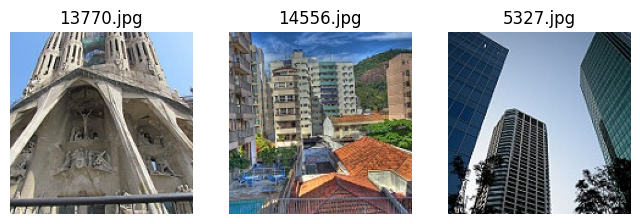

forest images:


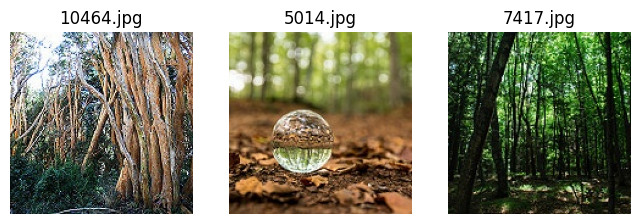

glacier images:


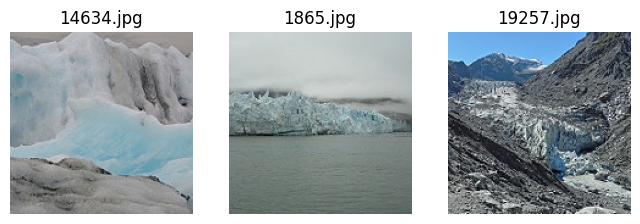

mountain images:


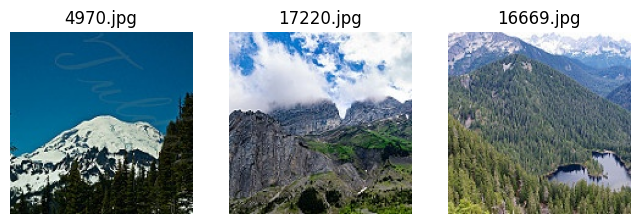

sea images:


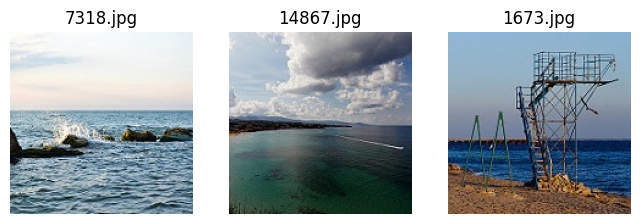

street images:


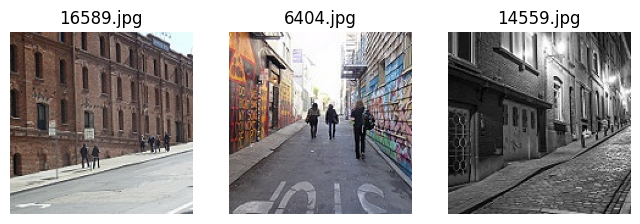

In [55]:
import matplotlib.pyplot as plt
import os
import cv2 as cv

print("type of Images in Train dataset"+str(os.listdir(train_dir)))
print("type of Images in Test dataset"+str(os.listdir(test_dir)))
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
rows, cols = (1, 3)
for labels in os.listdir(train_dir):
    print(f'{labels} images:')
    path = f'{train_dir}/{labels}'
    fig = plt.figure(figsize=(8, 4))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i+1)
        image_id = os.listdir(path)[np.random.randint(0, 2000)]
        image = cv.imread(path + f'/{image_id}')
        plt.imshow(image[:, :, ::-1])
        plt.title(image_id)
        plt.axis('off')
    plt.show()


In [ ]:
vgg16_model = VGG16(include_top=False, input_shape=(
    150, 150, 3), weights='imagenet')
vgg16_model.trainable = False
for layer in vgg16_model.layers:
  layer.trainble = False
custom_net = layers.Flatten()(vgg16_model.output)
custom_net = layers.Dropout(0.4)(custom_net) 

custom_net = layers.Dense(128, activation='relu')(custom_net)  
custom_net = layers.Dense(64, activation='relu')(custom_net)
custom_net = layers.Dense(32, activation='relu')(custom_net)
custom_net = layers.Dense(16, activation='relu')(custom_net)

output = layers.Dense(6, activation='softmax')(custom_net)
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=output)

for i, layer in (enumerate(vgg16_model.layers)):
    print(i, layer.name, layer.trainable)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

fBestModel = 'best_model_finetuned.h5'

best_model = ModelCheckpoint(
    fBestModel, verbose=1, save_best_only=True, monitor='accuracy', mode="max")

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_history = vgg16_model.fit(
    train_dataset, epochs=30, batch_size=128, callbacks=[best_model], validation_data=validation_dataset)


In [ ]:
import pickle
with open('./Histories/fineTunedHist.pkl','wb') as f:
  pickle.dump(train_history, f)


In [3]:
vgg16_model = tf.keras.models.load_model('./best_model_finetuned.h5')

In [10]:
test_data.labels
[0]

[0]

24/24 [==============================] - 36s 1s/step
Confusion matrix:


Text(0, 0.5, 'Prediction')

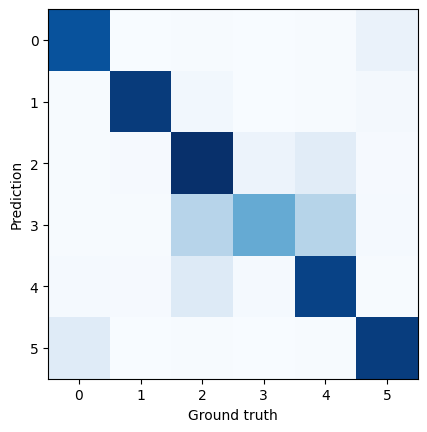

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_pred = vgg16_model.predict(test_data)

predicted_categories = np.argmax(y_pred, axis=1)

true_categories_argmax = np.argmax(test_data.labels, axis=0)

print('Confusion matrix:')
cm = confusion_matrix(test_data.labels, predicted_categories)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')


In [11]:
print(classification_report(test_data.labels, predicted_categories))


              precision    recall  f1-score   support

           0       0.85      0.92      0.89       437
           1       0.97      0.94      0.95       474
           2       0.68      0.84      0.75       553
           3       0.88      0.46      0.60       525
           4       0.69      0.85      0.76       510
           5       0.89      0.88      0.89       501

    accuracy                           0.81      3000
   macro avg       0.83      0.81      0.81      3000
weighted avg       0.82      0.81      0.80      3000



### Demo

In [53]:
model = tf.keras.models.load_model('./trainedModel')


In [18]:
IMAGE_RES = 150

def format_image(image):
    print(image.shape)
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
    print(image.shape)
    expanded_image = np.expand_dims(image, axis=0).copy()
    expanded_image.setflags(write=1)
    print(expanded_image.shape)

    # image_final = preprocess_input(expanded_image)
    # image_final.setflags(write=1)
    return expanded_image


In [19]:
def display_image(index, image):

    labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    print(labels[index])
    plt.figure()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Predicted Image {}  '.format(
        labels[index]))
    plt.show()


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib import pyplot as plt
import numpy as np
def predict_image(img_path, model):
  image = tf.keras.preprocessing.image.load_img(img_path, grayscale=False)
  image = tf.keras.preprocessing.image.img_to_array(image)
  image2 = image.copy()/255
  formatted_image = format_image(image)
  prediction = model.predict(formatted_image)
  print(prediction)
  prediction = np.argmax(prediction)
  display_image(prediction, image2)


(2825, 4253, 3)
(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[0.2058341  0.00743359 0.4017051  0.11891701 0.20926231 0.05684795]]
glacier


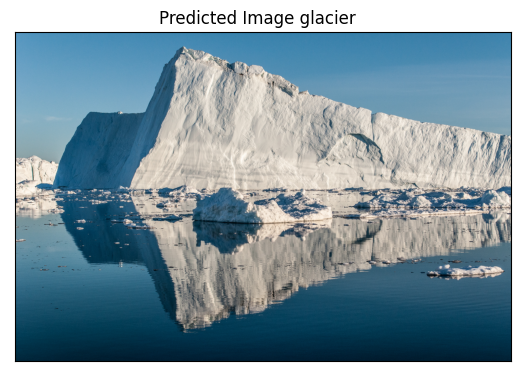

In [24]:
predict_image('./glacier.jpg', model)